## Inverse problems in image processing - TD 1
                                  
                                  e-mail: jayousi@unice.fr
                                  date: 6th Jan. 2023

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.linalg import circulant

# 1. Introduction

## 1.1 Fourier Transform

Load and display the two images.

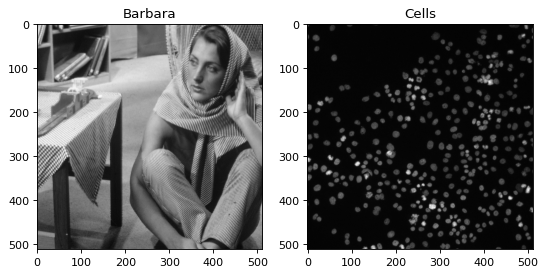

In [2]:
def scale(img):
  return (img - img.min()) / (img.max() - img.min()) * 255


# load the images
barb = np.float64(plt.imread("barbara.png"))
cells = np.float64(plt.imread("cells.png"))

# rescale the images in the range 0-255
barb = scale(barb)
cells = scale(cells)

# plot the images
plt.figure(figsize=(8, 4), dpi=80)
plt.subplot(1, 2, 1)
plt.imshow(barb, cmap="gray")
plt.title("Barbara")
plt.subplot(1, 2, 2)
plt.imshow(cells, cmap="gray")
plt.title("Cells")
plt.show()


Using the FFT (Fast Fourier Transform) compute the mangintude and phase spectrum of the two images.

In [3]:
fft_barb = np.fft.fft2(barb)
fft_cells = np.fft.fft2(cells)
fftshift_barb = np.fft.fftshift(fft_barb)
fftshift_cells = np.fft.fftshift(fft_cells)

# compute phase and magnitude of the Fourier transform
phase_barb = np.angle(fft_barb)
mag_barb = np.abs(fft_barb)
phase_cells = np.angle(fft_cells)
mag_cells = np.abs(fft_cells)

Then combine the magnitude spectrum of one image with the phase spectrum of the other and vice versa. What do you observe?

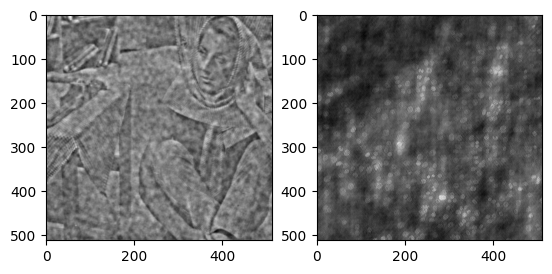

In [4]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

mix_phase_barb = np.real(np.fft.ifft2(mag_cells * np.exp(1j * phase_barb)))
mix_phase_cells = np.real(np.fft.ifft2(mag_barb * np.exp(1j * phase_cells)))
plt.subplot(1, 2, 1)
plt.imshow(mix_phase_barb, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(mix_phase_cells, cmap="gray")
plt.show()

## 1.2 Noise Generation

Add noise, $\eta$, to the "Barbara" image where

$$\eta \sim \mathcal{N}(0, \sigma^2 I)$$

Plot the original and the noisy image.  

_Hint_: you can use the np.random.randn() function

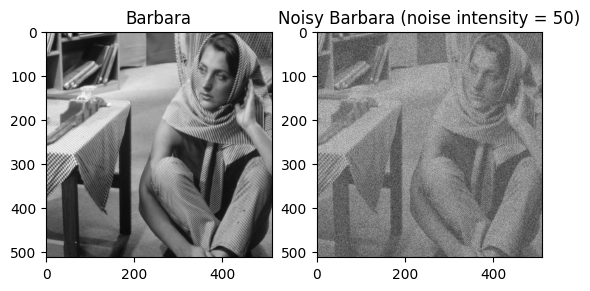

In [5]:
noise_intensity = 50
eta = np.random.normal(loc=0, scale=noise_intensity, size=[*fft_barb.shape])

plt.subplot(1, 2, 1)
plt.imshow(barb, cmap="gray")
plt.title("Barbara")
plt.subplot(1, 2, 2)
plt.imshow(barb + eta, cmap="gray")
plt.title(f"Noisy Barbara (noise intensity = {noise_intensity})")
plt.show()


To measure the strength of the original image $x_o$ relative to its noisy version $x_n$, we use the Signal-to-Noise Ratio (SNR) measure, defined as:

$$ \text{SNR}(x_o,x_n) = 20\log_{10} {\frac{ \|x_o\| }{ \|x_o-x_n\| } } $$ 

It is a quantity expressed in decibels (dB). The higher the SNR, the better the signal quality.

Compute the SNR between "Barbara" and its noisy version, for different noise levels (different $\sigma$). What do you observe?

In [6]:
def snr(img, eta) -> float:
  """
  Computes the signal-to-noise ratio (SNR) of an image.
  """
  return 20 * np.log10(np.linalg.norm(img) / np.linalg.norm(eta))
snr(img=barb, eta=eta)

8.257390870301734

Add Poisson noise to the "Barbara" image. The Poisson noise is signal dependenent and is generated from the data instead of being added. Plot the original and the noisy image. 

_Hint_: you can use the np.random.poisson() function

In [7]:
eta_poisson = np.random.poisson(barb)
eta_poisson


array([[184, 199, 227, ..., 112,  97,  86],
       [185, 202, 193, ...,  86,  90,  92],
       [189, 192, 184, ...,  71, 113,  98],
       ...,
       [108,  78,  95, ..., 124, 103, 124],
       [ 89,  99, 103, ..., 104, 100, 119],
       [ 84,  92,  97, ..., 107,  83, 106]])

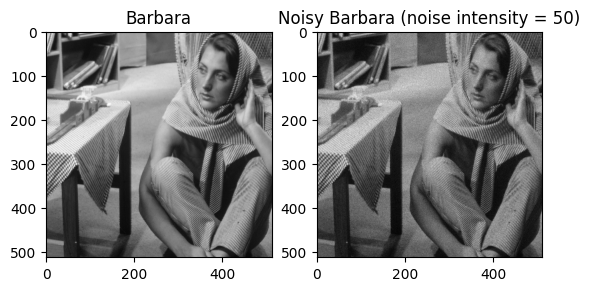

In [8]:
# add poisson noise to the image
plt.subplot(1, 2, 1)
plt.imshow(barb, cmap="gray")
plt.title("Barbara")
plt.subplot(1, 2, 2)
plt.imshow(eta_poisson, cmap="gray")
plt.title(f"Noisy Barbara (noise intensity = {noise_intensity})")
plt.show()

# compute the SNR of the noisy image
snr_poisson = 20 * np.log10(np.linalg.norm(barb) / np.linalg.norm(barb - eta_poisson))


Change the image brightness of the image and compute the SNR. What do you observe?

## 1.3 Image Blurring

We consider an image model where the observed image $y$ is a result of a degradation of an image $x$ by a linear transformation $f$, i.e.

$$
mat(y)=f(mat(x))
$$

where $mat(\cdot)$ is a notation used in this lab to underline that $f(mat(x))$ is an operation on a matrix $x$. 

Here $x$ and $y$ are images of size $512 \times 512$, then  $x\in \mathbb{R}^{512\times512}$ and  $y\in \mathbb{R}^{512\times512}$.

A common degradation is the blurring, achieved by convolving the image $x$ with a low-pass Gaussian filter kernel $h$. The blurred image $y$ is given by:

$$
mat(y)=mat(h)*mat(x) 
$$.

A common notation  is the matrix/vector notation:

$$
y= A x
$$

where $A$  is the matrix that does the convolution of the image $x$ by the Gaussian filter $h$. Here, $y$ and $x$ is the vectorized form of the images $mat(y)$ and $mat(x)$ respectiverly, in the lexical order. Then, $y\in \mathbb{R}^{N\times 1}$ and $x\in \mathbb{R}^{N\times 1}$ where $N$ is the number of pixels. It is important, as we will observe in the lab, that even though we use the notation for $A$, we do not actually construct the matrix. 

1. What is the number of pixel N in this example?

Ans: $512^2$

2. What is the size of the matrix $A$? 

Ans: $512^2 \times 512^2$

3. The matrix $A$ contains floats, how many GB is that given that one element uses 8 bytes?

Ans: $8 * 512^2 * 512^2 = 549,755,813,888 \approx 550 GB$

As you just observed, it is not always wise to create the full matrix $A$. So we will start by creating the function $f(mat(x))=mat(h)*mat(x)$, where $*$ denotes the convolution. Since convolution in time corresponds to multiplication in the frequency domain, we will do the convolution in the Fourier domain.

Compute the low pass Gaussian kernel with $\sigma=5$ pixels.  

The steps to create the convolution kernel is: 
1. Create a meshgrid of same size of the image (512x512). The center of the meshgrid could be 0. 
2. Apply the the Gaussian function onto the grid, and normalize the response such that the sum of all elements in the reponse =1. 
3. Apply the Fast Fourier Transformation. NOTE: If the center of the grid was defined as 0, a fftshift has to be done before applying the FFT2. 

In [41]:
sigma = 5
n = barb.shape[0]
# n = 10
t = np.concatenate([np.arange(0, n / 2 + 1), np.arange(-n / 2, -1)])
Y, X = np.meshgrid(t, t)
h = np.exp( - (X**2 + Y**2) / (2 * sigma**2))
h = h / np.sum(h)
hf = np.real(np.fft.fft2(h))

Plot the convolution kernel before and after the fourier transformation in the Fourier domain.  

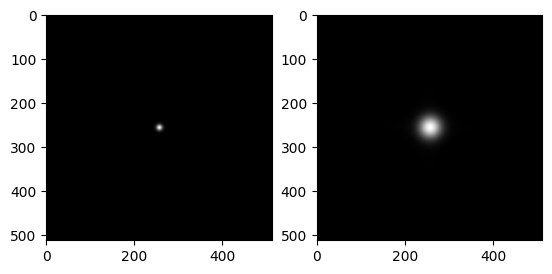

In [43]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(np.fft.fftshift(h), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(np.fft.fftshift(hf), cmap="gray")


Find the blurred image by computing the periodic convolution using FFTs.

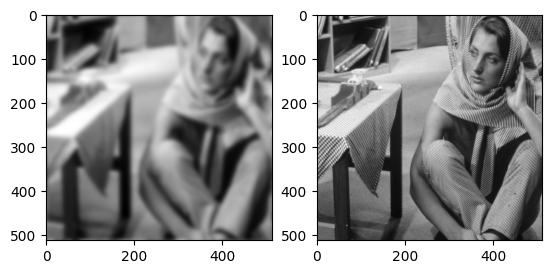

In [52]:
barb_gauss = np.real(np.fft.ifft2(hf * fft_barb))

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(barb_gauss, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(barb, cmap="gray")


# 2. Introduction to Inverse Problems

A more realistic model writes
$$
mat(y)=f(mat(x)) + mat(\eta) \qquad (1)
$$
where $mat(\cdot)$ is a notation used in this lab to underline that $f(mat(x))$ is an operation on a matrix $x$. 

A more common notation to write (1) is: 
$$
y= Ax + \eta
$$
where $A$ is the linear transformation and $x$, $y$ and $\eta$ are viewed as vectors. However, when working in image processing the matrix $A$ will rearly be constructed, and we will not reshape the image $x$ as a vector.  It is important, as we have observed in the lab, that even though we use the notations $A$, we do not actually construct the matrix. 

In this lab, we considerer that the noise, $\eta$ follows a multidimensional normal law of covarience $\sigma^2 I$ and of mean the zero vector. So, we can write: $\eta \sim \mathcal{N}(0, \sigma^2 I)$. 
  
The probability density function $p_\eta(\eta)$ is written as: 
\begin{equation}
 p_\eta(\eta) = \frac{1}{(2\pi\sigma^2)^{\frac{N}{2}}} \exp \left(-\frac{\|\eta\|_2^2}{2\sigma^2}\right)
\end{equation}
 where $N$ is the number of pixels and $\|\eta\|_p$ is the $l^p$-norm defined as: 
\begin{equation}
  \|\eta\|_p = \left(\sum_{i=1}^N |\eta|^p\right)^{\frac{1}{p}}
\end{equation}
 
 We want to find the unknown image $x$ from the observation $y$. Therefore, we use the  maximum likelihood estimation which maximizes the likelihood $L(y,x)$ with respect to the unknown image $x$. This likelihood is equal to the conditional probability of $y$ knowing $x$, denoted $p_{y|x}(y|x)$. The probability is calculated from the image model, supposing that the $\eta$ is white Gaussian noise. 

More precisely, the likelihood $L(y,x)$ is given by:
\begin{equation}
 L(y,x) = p_{y|x}(y|x) = p_n(n=Ax - y) = \frac{1}{(2\pi\sigma^2)^{\frac{N}{2}}} \textrm{exp}\left(-\frac{\|Ax-y\|_2^2}{2\sigma^2}\right)
\end{equation}

We search for an estimation $\hat{x}$ of the real image $x$ by maximizing the ligelihood  $L(y,x)$ as follows: 
\begin{equation}
 \hat{x} = \arg\max_x L(y,x)
\end{equation}

In order to avoid the difficulties related to the exponential, we often maximize the logarithm of the likelihood (which does not change the maximum argument since the logarithm is strictly increasing):
\begin{equation}
 \hat{x} = \arg\max_x \, \ln(L(y,x)) = \arg\max_x \, \left(- \ln \left(2\pi\sigma^2 \right)^{\frac{N}{2}} -\frac{1}{2\sigma^2}\|Ax-y\|_2^2\right)
\end{equation}

The term $- \ln \left( 2\pi\sigma^2 \right)^{\frac{N}{2}}$ is a constant with respect to $x$, and thus does not intervene in the estimation of $\arg\max$. Therefore, we can write:
\begin{equation}
 \hat{x} = \arg\max_x \, \left( -\frac{1}{2\sigma^2}\|Ax-y\|_2^2\right)
\end{equation}

The last step removes the proptionality coefficent $\frac{1}{2\sigma^2}$ and the negative sign by using the fact that  $\arg\max_x -f(x) = \arg\min_x f(x)$. So, finally: 

\begin{equation*}
 \hat{x} = \arg\min_x \, \|Ax-y\|_2^2 
\end{equation*}


Denote $J(x)=\|Ax-y\|_2^2 $. This term is in fact the Least Square term associated to the system $y = Ax$. The gradient of $J$ is $\nabla J(x)= 2A^*(Ax-y)$, where $A^*$ is the adjoint operator of A.

__QUESTION__ Find the explicit expression for $\hat{x}$ that satisfies $\nabla J(\hat{x})=0$.

 * Write the reply here

In order to find the minimum, instead of using Exact Least Square solution, we can make use of the gradient descent algorithm. The algorithm can be written as:

\begin{equation}
 x_{k+1} = x_k - \alpha 2 A^*(A x_k - y)
\end{equation}

with $k = 0 \dots K-1$, $x_0 = y$ and $0 < \alpha \leq \frac{1}{2}$.

## 2.1 Deconvolution Example

Let $y$ be a blured image (without adding any noise). Compute the exact solution $\hat{x}$ that satisfies $\nabla J(\hat{x})=0$, using FFT.

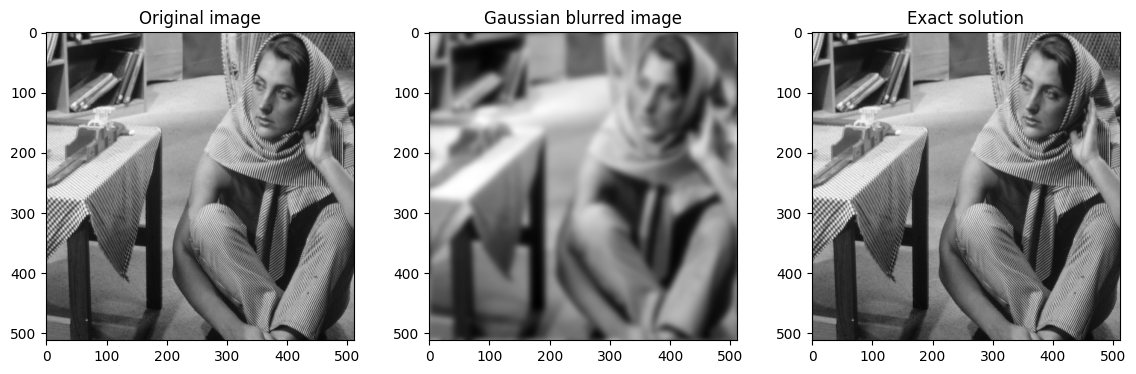

In [65]:
hf_adj = np.conj(hf)
exact_sol_barb = np.real(
  np.fft.ifft2(hf_adj * np.fft.fft2(barb_gauss) / np.abs(hf + 1e-16) ** 2)
)

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.title("Original image")
plt.imshow(barb, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("Gaussian blurred image")
plt.imshow(barb_gauss, cmap="gray")
plt.subplot(1, 3, 3)
plt.title("Exact solution")
plt.imshow(exact_sol_barb, cmap="gray")


Add white Gaussian noise (even a little bit) to the blurred image $y$ of the previous question. Compute again the exact solution $\hat{x}$ that satisfies $\nabla J(\hat{x})=0$, using FFT. What do you observe?

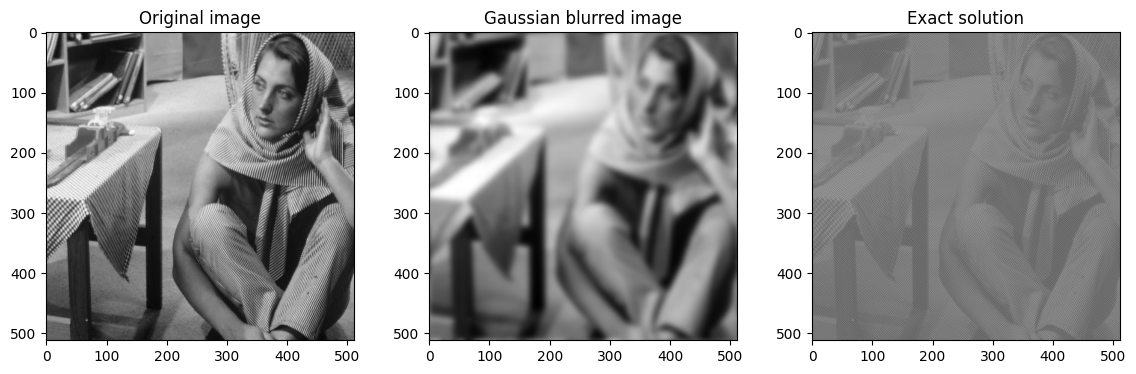

In [86]:
faulty_exact_sol_barb = np.real(
  np.fft.ifft2(
    hf_adj
    * (np.fft.fft2(barb_gauss + np.random.normal(0, 1e-3, size=(barb_gauss.shape))))
    / np.abs(hf + 1e-16) ** 2
  )
)

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.title("Original image")
plt.imshow(barb, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("Gaussian blurred image")
plt.imshow(barb_gauss, cmap="gray")
plt.subplot(1, 3, 3)
plt.title("Exact solution")
plt.imshow(faulty_exact_sol_barb, cmap="gray")


#### The importance of Matrix Condition number
The matrix condition number can be calculated, for an $A$ invertible, as 
$$
cond(A) = \|A\|\|A^{-1}\|
$$
Where $\|A\|= \sup_{x \neq 0} \frac{\|Ax\|}{\|x\|}$.
It can also be calculated  
$$cond(A) = \frac{\lambda_{max}}{\lambda_{min}}$$

If we have $y=Ax$, then $\|y\|\leq \|A\|\|x\|$.
If we have a small pertubation, then 
$y+\delta y = A(x+ \delta x)$, and $\delta y= A \delta x$. Which yields  $\|\delta x\|\leq \|A^{-1}\|\|\delta y\|$.
And thus, 

$$\frac{\|\delta x\|}{\|x\|}\leq\|A\| \|A^{-1}\|\frac{\|\delta y\|}{\|y\|}$$
or, equivalently
$$\frac{\|\delta x\|}{\|x\|}\leq cond(A) \frac{\|\delta y\|}{\|y\|}$$

Why is the Matrix Condition number important ? 
What is the condition number for our problem (remember that the eigen values of $A$ are given by (equal to) the coefficients of the Fourier transform of h)?  Is the problem ill-posed? 

#### Gradient Descent algorithm
In order to find the minimum, instead of using Exact Least Square solution, we can make use of the gradient descent algorithm. Recall that it is an iterative algorithm, while each update is given by:

\begin{equation}
 x_{k+1} = x_k - \alpha 2 A^*(A x_k - y)
\end{equation}

with $k = 0 \dots K-1$, $x_0 = y$ and $0 < \alpha \leq \frac{1}{2}$.

Complete the gradient descent function below, plot the cost/error function and the resulting image. The cost function should be constantly decreasing (debug your code otherwise!). What do you observe for different K?

In [ ]:
# -- Gradient Descent algo

#-- Parameters
alpha = None                   # Step
K = None                       # Number of iteration

# Initialisation
xk = None
J = np.zeros(shape=K)    # Cost
err = np.zeros(shape=K)  # Error 

# Loop
k = 0
while k < K:
    # gradient
    gradJ = None
    # update xk
    xk = xk - alpha * gradJ
    # Calculate cost and Error
    J[k] = None #  Cost function
    err[k] = None  # error between xk and the original image
    k += 1


# -- plots

# plot x
plt.subplot(1, 2, 1)
plt.imshow(x1, cmap='gray') 
plt.title('Original')
# plot xk
plt.subplot(1, 2, 2)
plt.imshow(xk, cmap= 'gray') 
plt.title('Restored Image')
plt.show()

# Estimation Error
plt.figure()
plt.semilogy(np.log(err)) 
plt.title('Estimation Error')

# Cost Function 
plt.figure()
plt.plot(J)
plt.title('Cost function evolution')
plt.grid(True)

* Write the reply here